In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
import numpy as np
import pandas as pd
from math import log
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv', index_col=False)

In [1011]:
from cmath import isnan


def process_df(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
    df = df.drop('Color', axis=1)
    df['Rating'] = df['Rating'].str.replace(',', '.')
    df['Rating'] = df['Rating'].astype(float)

    # if is_train:
    #     df['Brand weight'] = ""
    #     for category in df['Brand'].unique():
    #         total_rating = df.loc[df['Brand'] == category].count() / df.shape[0]
    #         df.loc[df['Brand'] == category, 'Brand weight'] = total_rating

    df = df.drop([
        'Name',
        'Category',
        # 'Min price',
        # 'Max price',
        # 'Average price',
        # 'Basic Sale',
        'full_category',
        'Seller',
        'Base price'
    ], axis=1)
    df['Days in stock/sales'] = df['Days with sales'].div(df['Days in stock'], axis=0).apply(
        lambda x: 1.0 if x >= 1.0 else 0 if isnan(x) else x)
    df['Comments-Rating'] = df['Comments'] * df['Rating']
    df['Rating-Days-Comments'] = np.exp(df['Days with sales']) * df['Rating'] * df['Comments']
    df['Price difference'] = np.exp(df['Average price'].fillna(0).div(df['Final price'], axis=0)) ** 3
    df['Min max price diff'] = np.log10((df['Max price'] - df['Final price']).apply(lambda x: 1 if x == 0 else x)) ** 3
    df['Days_Relation-Rating-Comments'] = df['Days in stock/sales'] * (df['Rating'] ** 2 * df['Comments']).apply(lambda x: 1 if x == 0 else x)
    df = df.drop(['Average price', 'Max price', 'Min price'], axis=1)

    return df.dropna() if is_train else df

In [1012]:
origin_train = process_df(train, True)
origin_test = process_df(test, False)
origin_test.drop('Id', axis=1, inplace=True)

origin_test

,Brand,Comments,Final price,Days in stock,Days with sales,Rating,Basic Sale,Basic Sale Price,Days in stock/sales,Comments-Rating,Rating-Days-Comments,Price difference,Min max price diff,Rating-Price
0,Majava,2.0,277.0,16.0,14,0.0,50.0,360.0,0.875000,0.0,0.000000e+00,17.885865,0.000000,0.875000
1,Beon,5.0,2211.0,7.0,8,3.0,40.0,2664.0,1.000000,15.0,4.471437e+04,20.085537,0.000000,45.000000
2,NEOLUX,19.0,490.0,31.0,22,5.0,30.0,490.0,0.709677,95.0,3.405667e+11,18.535758,0.000000,337.096774
3,CENTEK,2.0,807.0,31.0,0,4.0,15.0,807.0,0.000000,8.0,8.000000e+00,1.000000,0.000000,0.000000
4,HUAYU,3.0,426.0,31.0,5,5.0,3.0,426.0,0.161290,15.0,2.226197e+03,20.085537,1.505565,12.096774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,INDESIT,0.0,17803.0,31.0,3,0.0,23.0,19781.0,0.096774,0.0,0.000000e+00,20.085537,42.065928,0.096774
10737,Gelberk,8.0,897.0,12.0,9,4.0,54.0,1150.0,0.750000,32.0,2.592987e+05,20.085537,0.000000,96.000000
10738,Rowenta,15.0,1565.0,31.0,29,3.0,46.0,1565.0,0.935484,45.0,1.769100e+14,27.715964,30.522144,126.290323
10739,EREMON,0.0,2752.0,11.0,2,0.0,20.0,3440.0,0.181818,0.0,0.000000e+00,20.085537,0.000000,0.181818


In [1013]:
origin_test.shape

(10741, 14)

In [1014]:
origin_train.shape

(25061, 15)

In [1015]:
def get_histogram(df: pd.DataFrame, name: str):
    vals = sorted(df[name].unique())

    bins = 1 + log(len(vals), 2)
    min = vals[0]
    max = vals[len(vals) - 1]
    length = (max - min) / bins

    intervals = [min + length * i for i in range(int(bins) + 1)]
    plt.hist(vals, histtype='stepfilled', bins=intervals)

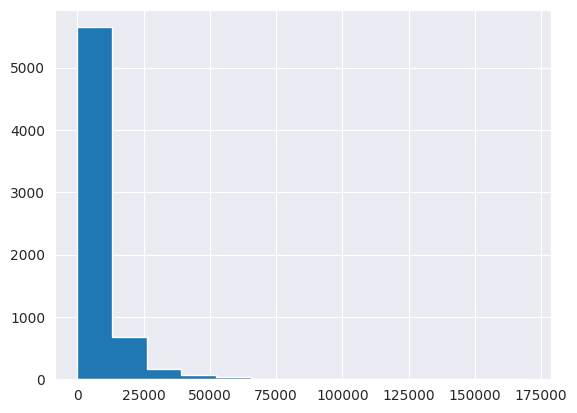

In [1016]:
get_histogram(origin_train, 'Final price')

In [1017]:
features = origin_train.drop(['Sales'], axis=1)
target = origin_train['Sales']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [1018]:
# def clear_column_from_extremes(data_frame: pd.DataFrame, col_name: str):
#     column = data_frame[col_name]
#     q = np.nanquantile(column, q=[0.25, 0.75])
#     low = q[0] - 1.5 * (q[1] - q[0])
#     high = q[1] + 1.5 * (q[1] - q[0])
#
#     for index, row in data_frame.iterrows():
#         aux = data_frame[col_name].loc[index]
#         if not (low <= aux < high) and np.isnan(data_frame["G_total"].loc[index]):
#            data_frame.drop(index, inplace=True)
#     return data_frame

In [1019]:
def delete_nan_cols(df: pd.DataFrame):
    new_df = df
    nan_count_series = new_df.isna().sum()
    column_size = new_df.shape[0]

    for i, v in nan_count_series.items():
        if (v / column_size) * 100 > 45:
            print(f'Deleted {i}')
            new_df = new_df.drop(i, axis=1)

    return new_df

In [1020]:
print(len(list(delete_nan_cols(X_train).columns.values)))
print(len(list(X_train.columns.values)))

14
14


In [1021]:
label_encoder = LabelEncoder()

In [1022]:
def categorize_columns(data: pd.DataFrame):
    categorical_columns = data.columns[data.dtypes == 'object']
    print(categorical_columns)

    for column in categorical_columns:
        data[column] = label_encoder.fit_transform(data[column])

In [1023]:
categorize_columns(X_train)
categorize_columns(X_test)
categorize_columns(origin_test)
categorize_columns(origin_train)

Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')


<AxesSubplot: >

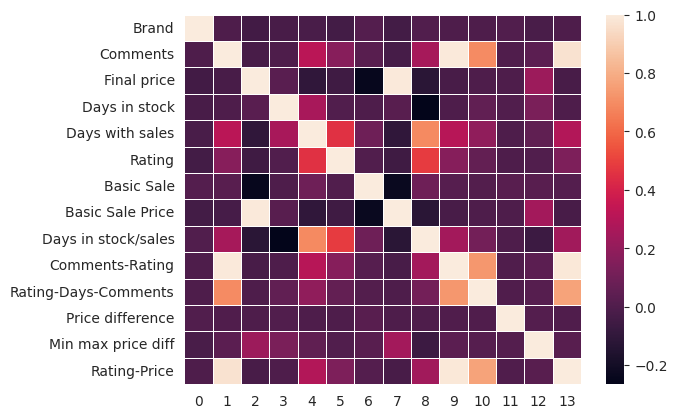

In [1024]:
cor = X_train.corr()
plt.clf()
sns.heatmap(cor, xticklabels=range(X_train.shape[1]), yticklabels=1, linewidths=.5)

In [1025]:
feature_model = RandomForestRegressor(verbose=999, max_depth=None, random_state=42)

feature_model.fit(X_train, y_train)
print(feature_model.feature_importances_, feature_model.feature_names_in_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining: 

In [1026]:
# params = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.1],
#     'min_samples_leaf': [4, 5, 6],
#     'loss': ['absolute_error'],
#     'l2_regularization': [0.1, 0.2, 0.05],
#     'max_bins': [50, 100, 150],
#     'max_depth': [None],
#     'max_leaf_nodes': [None, 5, 6, 8],
#     'validation_fraction': [0.01, 0.1, 0.2]
# }
#
# boost_model = GridSearchCV(
#     HistGradientBoostingRegressor(max_iter=1000, max_bins=100, random_state=42),
#     params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=999
# )
#
# boost_model.fit(X_train, y_train)
# # learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=30, max_iter=1000, loss='absolute_error', l2_regularization=0.02, max_bins=100, validation_fraction=0.02, random_state=42
#
# # learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=4, max_iter=1000, loss='absolute_error', l2_regularization=0.2, max_bins=100, validation_fraction=0.01, random_state=42
#
# # 'l2_regularization': 0.05,
# #  'learning_rate': 0.01,
# #  'loss': 'absolute_error',
# #  'max_bins': 150,
# #  'max_depth': None,
# #  'max_leaf_nodes': None,
# #  'min_samples_leaf': 6,
# #  'validation_fraction': 0.2

In [1027]:
# boost_model.best_params_

In [1028]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
#
# pipeline = make_pipeline(
#     PolynomialFeatures(degree=3),
#     SelectKBest(mutual_info_regression, k=10)
# )
#
# poly_features = pipeline.fit_transform(X_train, y_train)
# poly_features

In [1029]:
# import xgboost as xgb
#
# xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bynode=1, colsample_bytree=1, gamma=0,
#        importance_type='gain', learning_rate=0.1, max_delta_step=0,
#        max_depth=3, min_child_weight=1, missing=True, n_estimators=100,
#        n_jobs=1,random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#        silent=None, subsample=1, verbosity=1)
# xgb_model.fit(X_train, y_train)

In [1030]:
boost_model = HistGradientBoostingRegressor(learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=8,
                                            max_iter=10000, loss='absolute_error', l2_regularization=0.02, max_bins=156, # 245, 200
                                            validation_fraction=0.01, random_state=46)

boost_model.fit(X_train, y_train)

Binning 0.002 GB of training data: 0.021 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.56109, val loss: 29.02310, in 0.010s
[2/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.47259, val loss: 28.93656, in 0.009s
[3/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.38481, val loss: 28.85090, in 0.014s
[4/10000] 1 tree, 31 leaves, max depth = 10, train loss: 39.29800, val loss: 28.76615, in 0.005s
[5/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.21207, val loss: 28.68202, in 0.015s
[6/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.12736, val loss: 28.59963, in 0.005s
[7/10000] 1 tree, 31 leaves, max depth = 9, train loss: 39.03590, val loss: 28.51315, in 0.006s
[8/10000] 1 tree, 31 leaves, max depth = 9, train loss: 38.94541, val loss: 28.42753, in 0.006s
[9/10000] 1 tree, 31 leaves, max depth = 9, train loss: 38.85587, val loss: 28.34277, in 0.005s
[10/10000] 1 t

HistGradientBoostingRegressor(l2_regularization=0.02, learning_rate=0.01,
                              loss='absolute_error', max_bins=156,
                              max_iter=10000, min_samples_leaf=8,
                              random_state=46, validation_fraction=0.01,
                              verbose=999)

In [1031]:
# SelectKBest(mutual_info_regression, k=9).fit_transform(X_train, y_train)

In [1032]:
def score(predicted: np.ndarray, expected: np.ndarray):
    def smape(A, F):
        return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

    print(f'Smape: {smape(expected, predicted)}')
    print(f'R2: {r2_score(expected, predicted)}')
    print(f'RMSE: {mean_squared_error(expected, predicted)}')

In [1033]:
def postprocess(output: np.ndarray) -> np.ndarray:
    squarer = lambda t: round(t)
    vfunc = np.vectorize(squarer)
    return vfunc(output)

In [1034]:
predicted = postprocess(boost_model.predict(X_test))
print(predicted)
print(y_test)
score(predicted, y_test)
# 20.727624784060993

[126   0   0 ...  27   0   0]
4375      85.0
6682       0.0
23737      0.0
5324     204.0
17068    106.0
         ...  
24667      0.0
24589      0.0
20333     19.0
14736      0.0
16083      0.0
Name: Sales, Length: 8271, dtype: float64
Smape: 19.427030858053463
R2: 0.3077044880542944
RMSE: 33992.37794704389


In [1035]:
boost_model = HistGradientBoostingRegressor(learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=4,
                                            max_iter=10000, loss='absolute_error', l2_regularization=0.02, max_bins=100,
                                            validation_fraction=0.001, random_state=46)

boost_model.fit(origin_train.drop(['Sales'], axis=1).values, origin_train['Sales'])

Binning 0.003 GB of training data: 0.055 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 9, train loss: 38.57388, val loss: 62.39231, in 0.007s
[2/10000] 1 tree, 31 leaves, max depth = 8, train loss: 38.48668, val loss: 62.30992, in 0.096s
[3/10000] 1 tree, 31 leaves, max depth = 8, train loss: 38.40035, val loss: 62.22836, in 0.100s
[4/10000] 1 tree, 31 leaves, max depth = 8, train loss: 38.31489, val loss: 62.14762, in 0.010s
[5/10000] 1 tree, 31 leaves, max depth = 8, train loss: 38.23028, val loss: 62.06768, in 0.007s
[6/10000] 1 tree, 31 leaves, max depth = 8, train loss: 38.14693, val loss: 61.98854, in 0.054s
[7/10000] 1 tree, 31 leaves, max depth = 9, train loss: 38.05689, val loss: 61.89635, in 0.009s
[8/10000] 1 tree, 31 leaves, max depth = 8, train loss: 37.96769, val loss: 61.80508, in 0.007s
[9/10000] 1 tree, 31 leaves, max depth = 8, train loss: 37.87936, val loss: 61.71472, in 0.012s
[10/10000] 1 tr

HistGradientBoostingRegressor(l2_regularization=0.02, learning_rate=0.01,
                              loss='absolute_error', max_bins=100,
                              max_iter=10000, min_samples_leaf=4,
                              random_state=46, validation_fraction=0.001,
                              verbose=999)

In [1036]:
predicted = postprocess(boost_model.predict(origin_test.values))
df_inference = pd.DataFrame(data=predicted, index=range(0, len(predicted)), columns=['Expected'])
df_inference.index.name = 'Id'

df_inference.to_csv('../submissions/inference.csv')

In [1037]:
origin_test.to_csv('../processed-datasets/processed_test-19.58.csv')
origin_train.to_csv('../processed-datasets/processed_train-19.58.csv')